In [2]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series

import pyodbc
import pickle
import pandas.core.algorithms as algos
import scipy
from scipy.stats import levene
import re

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [2]:
#Derive products launched in June 

In [3]:
# SQL connection
server = 'flworkshop.database.windows.net'
database = 'FL_WORKSHOP'
username = 'sqluser'
password = 'flazure@17'

cnxn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
def extract_data(sql):
    cnxn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
    cursor = cnxn.cursor()
    cursor.execute(sql)
    temp = cursor.fetchall()    
    for i in range(0,len(temp)):
        temp[i]=tuple(temp[i])    
    columns = [column[0] for column in cursor.description]
    data = pd.DataFrame(temp,columns=columns)
    return data

Error: ('01000', "[01000] [unixODBC][Driver Manager]Can't open lib 'ODBC Driver 13 for SQL Server' : file not found (0) (SQLDriverConnect)")

### Finding trends of products launched in June

In [41]:
june_prods= extract_data(sql= "select sku, store_number, "\
                    " business_date,sales_amount, sales_units "\
                    " from temp_store_transaction_detail_US_201712_2 "\
                    " where sku in ( "\
                    " SELECT sku "\
                    " from temp_store_transaction_detail_US_201712_2"\
                    " where sales_units !=0 "\
                    " group by sku "\
                    " having month(min(business_date)) = 6)")

In [42]:
june_prods.shape

(2617806, 5)

### june_prod pickle file 

In [43]:
# #DownLoad the pickle file
# data_pkl = open('june_prods.pkl', 'wb')
# pickle.dump(june_prods, data_pkl)
# data_pkl.close()

In [23]:
#uploadd the pickle file 
data_pkl = open('june_prods.pkl', 'rb')
june_prods = pickle.load(data_pkl)

In [24]:
june_prods.sku.nunique()

5274

In [25]:
june_prods = june_prods.sort_values('business_date')
june_x = june_prods.copy()
june_x = june_x[june_x['sales_units']>0]
june_x['business_date'] = pd.to_datetime(june_x['business_date'], format= "%Y-%m-%d")
min_date= pd.DataFrame(june_x.groupby(['sku', 'store_number'])['business_date'].min())
min_date = min_date.reset_index()

june_launch = min_date[min_date['business_date']<'2017-07-01']
june_x = pd.merge(june_x, june_launch, how= 'right', left_on = ['sku', 'store_number'], 
              right_on = ['sku', 'store_number'])

In [26]:
june_x.shape

(1450444, 6)

In [27]:
def week(row):
    if row['time_gap']<7.0:
        week = 'week1'
    elif row['time_gap']<14.0:        
        week = 'week2'
    elif row['time_gap']<21.0:        
        week = 'week3'
    elif row['time_gap']<28.0:        
        week = 'week4'
    else:       
        week = 'week5+'
    return week     

In [28]:
june_x['time_gap']= (june_x['business_date_x']-june_x['business_date_y'])/np.timedelta64(1,'D')
june_x.time_gap = june_x.time_gap.astype(int)
june_x['week']= june_x.apply(lambda row: week(row), axis=1)

In [71]:
june_x.columns = ['sku', 'store_number', 'business_date', 'sales_amount', 'sales_units',
       'launch_date', 'day_of_sale_after_launch', 'week_of_sale_after_launch']

In [70]:
june_x.sample(5)

,sku,store_number,business_date,sales_amount,sales_units,launch_date,day_of_sale_after_launch,week_of_sale_after_launch
646305,18410498004,1814423,2017-06-29,110.00,1,2017-06-16,13,week2
1058471,08925045100,0840200,2017-07-20,14.00,1,2017-06-23,27,week4
281938,03627171604,0306959,2017-06-24,162.00,1,2017-06-09,15,week3
979664,03524070302,0307116,2017-07-13,190.00,1,2017-06-22,21,week4
209184,29411401204,2957222,2017-08-14,120.00,1,2017-06-09,66,week5+


In [72]:
x_sku_agg_sales = june_x.groupby(['sku','week_of_sale_after_launch'])['sales_units'].sum()
x_sku_agg_sales_df = x_sku_agg_sales.reset_index()
x_sku_agg_sales_df.columns = ['sku', 'week_of_sale_after_launch', 'sales_units_in_week']

x_sku_agg_pct   = x_sku_agg_sales.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
x_sku_agg_pct = x_sku_agg_pct.reset_index()
x_sku_agg_pct.columns = ['sku','week_of_sale_after_launch','sales_units_perc']

In [101]:
x_sku_agg_sales_df = x_sku_agg_sales_df.sort_values('sku', ascending = True)

In [106]:
x_sku_agg_pct.sample(5)

,sku,week_of_sale_after_launch,sales_units_perc,sales_perc_group
1886,03648448304,week4,4.255319,0-20% of total sales
4776,08787588300,week3,3.333333,0-20% of total sales
212,03410651004,week4,3.232462,0-20% of total sales
3530,03881023400,week1,100.000000,80-100% of total sales
8366,18730015900,week3,5.714286,0-20% of total sales


In [73]:
x_sku_agg_pct.head(5)
def week_type(row):
    if row['sales_units_perc']<20:
        type_ = '0-20% of total sales'
    elif row['sales_units_perc']<40:        
        type_= '20-40% of total sales'
    elif row['sales_units_perc']<60:        
        type_= '40-60% of total sales'
    elif row['sales_units_perc']<80:        
        type_= '60-80% of total sales'
    else:       
        type_ = '80-100% of total sales'
    return type_
x_sku_agg_pct['sale_type'] = x_sku_agg_pct.apply(lambda row:week_type(row), axis=1)

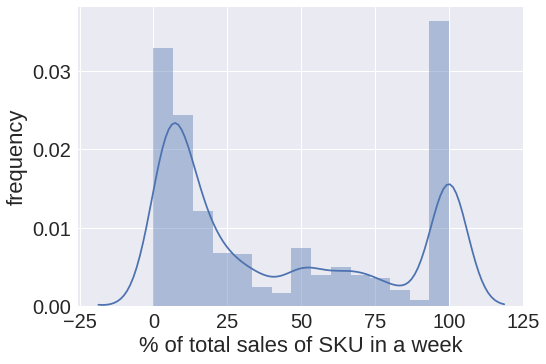

In [96]:
sns.set(font_scale = 2)
ax= sns.distplot(x_sku_agg_pct['sales_units_perc'].values)
ax.set(xlabel='% of total sales of SKU in a week', ylabel='frequency')
plt.show()

# ax.xlim(-5,100)
# ax.ylim(-5,25000)
# plt.xlabel('number of units sold for sku',size =18)
# plt.ylabel('Number of skus',size = 18)
# plt.xticks(size =20)
# plt.yticks(size=20)

In [74]:
x_sku_agg_pct.columns = ['sku', 'week_of_sale_after_launch', 'sales_units_perc', 'sales_perc_group']

In [85]:
x_sku_agg_pct.sample(5)

,sku,week_of_sale_after_launch,sales_units_perc,sales_perc_group
6379,16889466500,week2,8.875740,0-20% of total sales
6741,16968986900,week1,9.000000,0-20% of total sales
6862,18410534204,week2,9.134008,0-20% of total sales
2206,03730887800,week1,100.000000,80-100% of total sales
2967,03739701800,week2,9.128631,0-20% of total sales


In [78]:
# total sales of SKUs 

In [107]:
sku_overall_sales = june_x.groupby('sku')['sales_units'].sum()
sku_overall_sales = sku_overall_sales.reset_index()

In [108]:
sku_overall_sales.columns

Index(['sku', 'sales_units'], dtype='object')

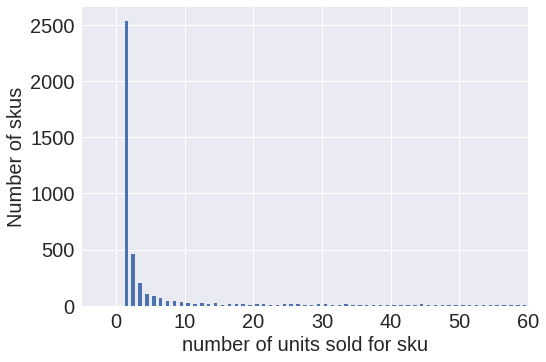

In [112]:
bins_list = list(range(1,100))
bins_given = bins_list + [sku_overall_sales.sales_units.max()]
plt.hist(sku_overall_sales['sales_units'], bins = bins_given, rwidth = 0.5)
plt.xlim(-5,60)
plt.xlabel('number of units sold for sku',size =20)
plt.ylabel('Number of skus',size = 20)

### Total SKU sales 

In [61]:
total_sku_overall_sales = extract_data(sql= "select sku,sum(sales_units) as total_units_sold "\
                    " from temp_store_transaction_detail_US_201712_2"\
                    " group by sku")

In [98]:
# #DownLoad the pickle file
# data_pkl = open('total_sku_overall_sales.pkl', 'wb')
# pickle.dump(total_sku_overall_sales, data_pkl)
# data_pkl.close()

In [113]:
data_pkl = open('total_sku_overall_sales.pkl', 'rb')
total_sku_overall_sales = pickle.load(data_pkl)

In [114]:
total_sku_overall_sales.sku.nunique()

117214

In [115]:
total_sku_overall_sales.sample(5)

,sku,total_units_sold
20801,03647091704,9
77088,18716201300,9
56166,16647640604,3
106940,29658179304,1
64216,16938020300,5


In [116]:
total_sku_overall_sales.total_units_sold.max()

265573

In [117]:
print(total_sku_overall_sales[total_sku_overall_sales['total_units_sold']== 1].shape)
print(total_sku_overall_sales[total_sku_overall_sales['total_units_sold']>19].shape)


(23455, 2)
(51539, 2)


(array([ -5000.,      0.,   5000.,  10000.,  15000.,  20000.,  25000.]),
 <a list of 7 Text yticklabel objects>)

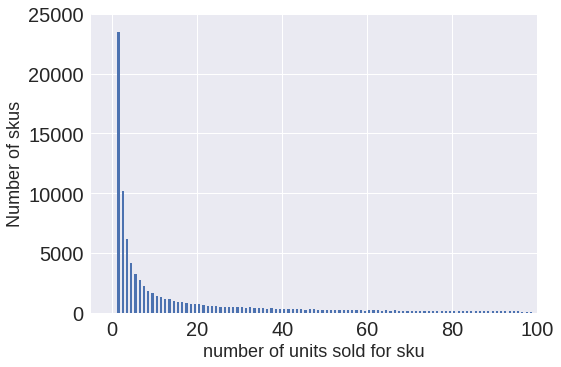

In [118]:
bins_list = list(range(1,100))
bins_given = bins_list + [total_sku_overall_sales.total_units_sold.max()]
plt.hist(total_sku_overall_sales['total_units_sold'], bins = bins_given, rwidth = 0.5)
plt.xlim(-5,100)
plt.ylim(-5,25000)
plt.xlabel('number of units sold for sku',size =18)
plt.ylabel('Number of skus',size = 18)
plt.xticks(size =20)
plt.yticks(size=20)

##### considering only products which have atleast 100 units sold across the stores

In [93]:
sku_overall_sales_sub = sku_overall_sales[sku_overall_sales.sales_units > 20]

In [94]:
skus_with_min_sales = sku_overall_sales_sub.sku.unique()

In [126]:
sku_agg_sales = june_x[['sku','sales_units']].groupby('sku')['sales_units'].sum()
sku_agg_sales = sku_agg_sales.reset_index()
skus_with_min_sales = sku_agg_sales[sku_agg_sales['sales_units']>10].sku.unique()

In [127]:
x_sku_agg_pct_subset = x_sku_agg_pct[x_sku_agg_pct['sku'].isin(skus_with_min_sales)]

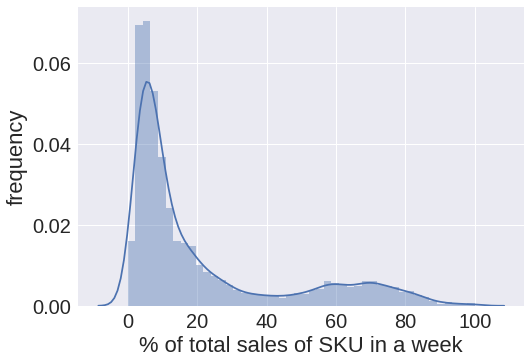

In [128]:
sns.set(font_scale = 2)
ax= sns.distplot(x_sku_agg_pct_subset['sales_units_perc'].values)
ax.set(xlabel='% of total sales of SKU in a week', ylabel='frequency')
plt.show()

array(['week1', 'week2', 'week3', 'week4', 'week5+'], dtype=object)

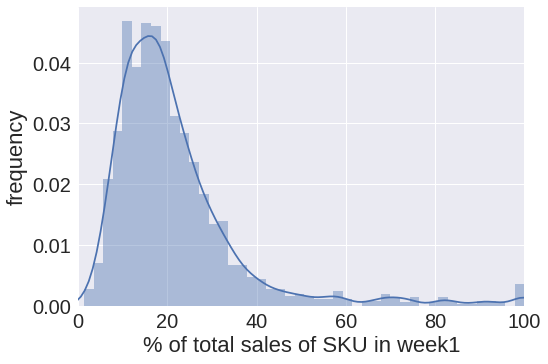

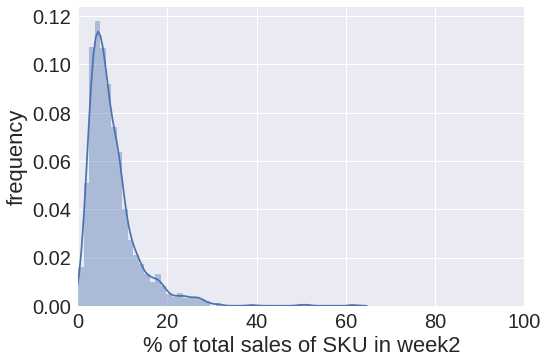

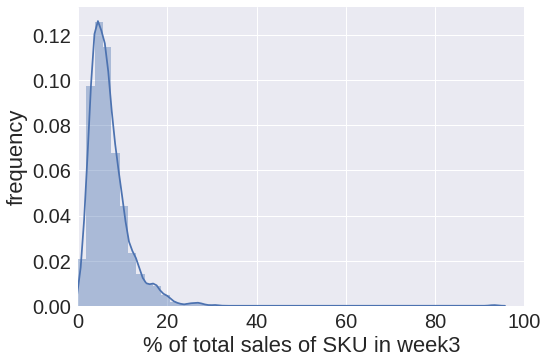

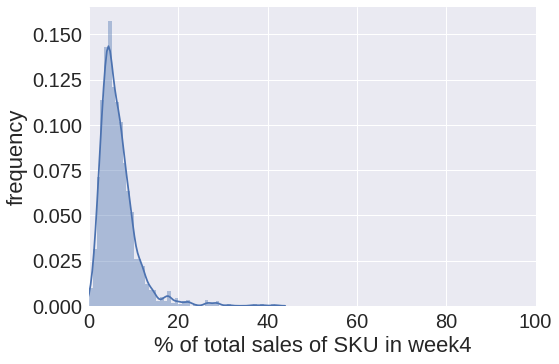

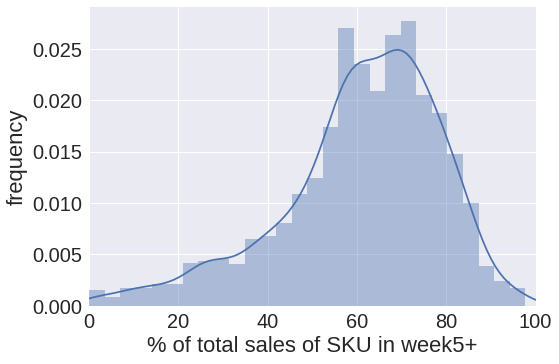

In [137]:
for week in list(x_sku_agg_pct_subset.week_of_sale_after_launch.unique()):
    x_sku_agg_pct_subset_week = x_sku_agg_pct_subset[x_sku_agg_pct_subset.week_of_sale_after_launch == week]
    sns.set(font_scale = 2)
    ax= sns.distplot(x_sku_agg_pct_subset_week['sales_units_perc'].values)
    ax.set(xlabel='% of total sales of SKU in ' + str(week), ylabel='frequency')
    ax.set_xlim(0,100)
    plt.show()

In [96]:
x_sku_agg_pct_subset.sku.nunique()

1514

In [97]:
x_sku_agg_pct.head(5)
pd.pivot_table(x_sku_agg_pct_subset, values='sku', index=['week_of_sale_after_launch'],
                   columns=['sales_perc_group'], aggfunc=lambda x: len(x.unique()))

sales_perc_group,0-20% of total sales,20-40% of total sales,40-60% of total sales,60-80% of total sales,80-100% of total sales
week_of_sale_after_launch,,,,,
week1,893.0,516.0,61.0,21.0,23.0
week2,1368.0,39.0,1.0,1.0,NaN
week3,1380.0,14.0,NaN,NaN,1.0
week4,1390.0,14.0,NaN,NaN,NaN
week5+,50.0,119.0,432.0,713.0,175.0
